In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_neuro_perf
from matlab.matlab_lib import loadmat
from qt_wrapper import gui_fpath

Appended library directory /home/alyosha/work/git/TNU2019-Project/src/lib


## 0. Loading data

In [2]:
# Read LVM file from command line
#data_path = gui_fpath("Select data directory", './')
data_path = '../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour'
data, behaviour = read_neuro_perf(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

#pd.DataFrame(behaviour['trials'])

Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour
Loaded neuronal data with (nTrials, nTimes, nChannels)= (590, 201, 12)


# 1. Autoregression

Numerically solving the *AR(1)* model over multiple trials

$$X_{ijk} = A_{il}X_{lj(k-1)} + \epsilon_{ijk}$$

where the dimensions of X are *(Channel, Trial, TimeStep)*. Note that einstein summation over repeating indices is used wherever explicit summation operator is not present. In particular, the L_1-regularized loss function is given by

$$L^2 = \sum_{ijk}|X_{ijk} - A_{il}X_{lj(k-1)}|^2 + c||A||_1$$

In order to optimize numerical computation of $L^2$, some summations can be performed without explicit knowledge of the matrix $A$. Expanding all squares, we notice that sums over $j$ and $k$ do not depend on $A$, so the loss function can be rewritten as

$$L_2 = D^1 - 2 A_{ij} D^{10}_{ij} + D^{00}_{kl}A_{ik}A_{il}$$

where
$$
\begin{eqnarray}
  D^1 &=& \sum_{ijk}|X_{ijk}|^2 \\
  D^{10}_{ab} &=& X_{ajk} X_{bj(k-1)} \\
  D^{00}_{ab} &=& X_{aj(k-1)} X_{bj(k-1)}
\end{eqnarray} $$

Thus, in above, all matrices have dimensions (nChannel, nChannel), avioding the need to do expensive sums over time steps and trials on each iteration

**Results**:
* $L_1$-norm works as expected - most values in the resulting matrix are effectively zero.
* Positivity constraint works - all entries of the resulting matrix are positive
* It appears that under above constraints the matrix is not strictly positive. For example, channel 0 depends only on the past value of the channel 3, but not on its own past

In [3]:
def unpack(Aarr):
    return Aarr.reshape(nChannels, nChannels)

def model(Data, A):   # Future time step from prev. one
    return Data.dot(A.T)

# def L(Aarr):
#     Amat = unpack(Aarr)
#     data_guess = model(data, Amat)
#     residue = np.linalg.norm(data[:, 1:, :] - data_guess[:, :-1, :])
#     return residue

d_0 = data[:, :-1, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
d_1 = data[:, 1:, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
len_d = d_0.shape[1]

D1 = np.linalg.norm(d_1)**2
D10  = np.einsum('ij, kj', d_1, d_0)
D00 = np.einsum('kj, lj', d_0, d_0)

C_REG = 5.0

def reg(Amat):
    return C_REG*np.sum(np.abs(Amat))

def L2_fast(Aarr):
    Amat = unpack(Aarr)
    B = -2*np.einsum('ij, ij', Amat, D10)
    C = np.einsum('ik,il,kl', Amat, Amat, D00)
    return D1 + B + C + reg(Amat)

def L2_jac(Aarr):
    Amat = unpack(Aarr)
    Jac2D = -2 * (D10 - Amat.dot(D00)) + C_REG*np.sign(Amat)
    return Jac2D.flatten()

/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


False
Desired error not necessarily achieved due to precision loss.
True
Optimization terminated successfully.
4.673692737930355 compared to 31.142783566956066


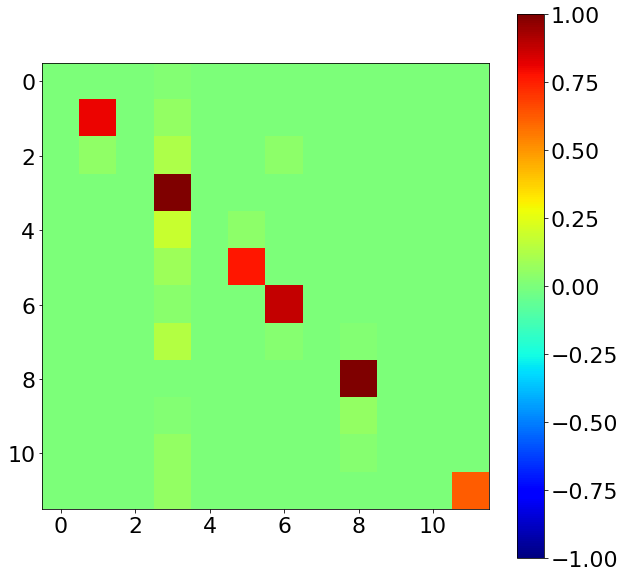

CPU times: user 1.03 s, sys: 371 ms, total: 1.41 s
Wall time: 653 ms


In [6]:
%%time
A0arr = np.diag(np.ones(nChannels)).flatten() + np.random.uniform(0, 0.1, nChannels**2)

# To accelerate convergence, first optimize using Conjugate Gradient, then reuse result and optimize using SLSQP
bounds = [(0, 10) for i in range(nChannels**2)]
min_obj = scipy.optimize.minimize(L2_fast, A0arr, jac=L2_jac, bounds=bounds, method='CG')#, method='SLSQP')
print(min_obj.success)
print(min_obj.message)
# min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='L-BFGS-B')
# print(min_obj.success)
# print(min_obj.message)
min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='SLSQP')
print(min_obj.success)
print(min_obj.message)

A = unpack(min_obj.x)
A[A < 1.0e-10] = 0

# Compute fitness
L2_without_reg = np.sqrt(min_obj.fun - reg(A))
print(L2_without_reg, "compared to", np.linalg.norm(data[:, 1:, :]))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.imshow(unpack(min_obj.x), vmin=-1, vmax=1, cmap='jet')
plt.colorbar()
plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000e+00,0.0,0.016346,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,8.064115e-01,0.0,0.059426,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,5.602257e-02,0.0,0.123012,0.0,1.760239e-08,0.045214,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.000000e+00,0.0,0.998702,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,3.321991e-08,0.0,0.184806,0.0,4.200333e-02,0.000000,0.0,0.000000,0.0,0.0,0.000000
5,0.0,0.000000e+00,0.0,0.083898,0.0,7.746754e-01,0.000000,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.000000e+00,0.0,0.033937,0.0,0.000000e+00,0.887416,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.000000e+00,0.0,0.137518,0.0,0.000000e+00,0.036267,0.0,0.022592,0.0,0.0,0.000000
8,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000e+00,0.000000,0.0,0.992660,0.0,0.0,0.000000
9,0.0,0.000000e+00,0.0,0.000249,0.0,0.000000e+00,0.024148,0.0,0.054465,0.0,0.0,0.000000


/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


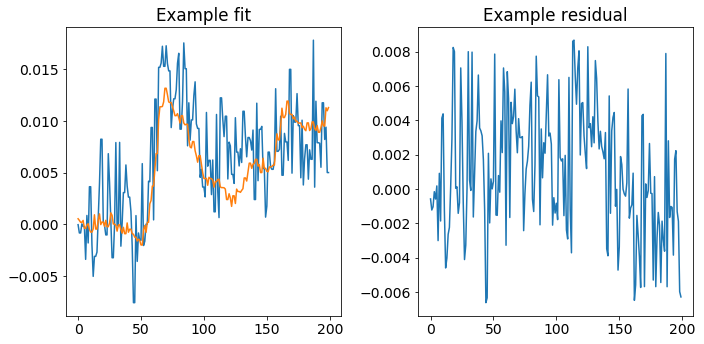

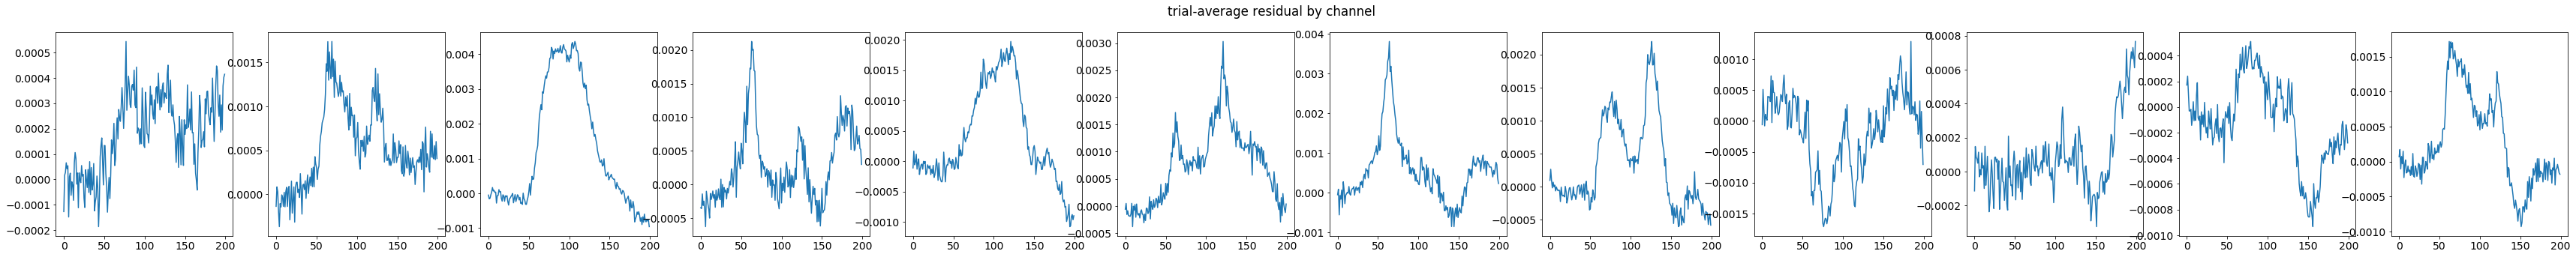

In [5]:
display(pd.DataFrame(A))

Data_model = model(data[:, :-1, :], A)
Residual = data[:, 1:, :] - Data_model

plt.rcParams.update({'font.size': 14})

N_CH = 2
fig, ax = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
ax[0].set_title("Example fit")
ax[1].set_title("Example residual")
ax[0].plot(data[0, 1:, N_CH])
ax[0].plot(Data_model[0, :, N_CH])
ax[1].plot(Residual[0, :, N_CH])
plt.show()

fig, ax = plt.subplots(ncols=nChannels, figsize=(5*nChannels, 5))
fig.suptitle("trial-average residual by channel")
for i in range(nChannels):
    ax[i].plot(np.average(Residual[:, :, i], axis=0))
plt.show()